In [1]:
from data.dataset import ICDR2015Dataset
import matplotlib.pyplot as plt

%load_ext autoreload
%autoreload 2

In [2]:
dset = ICDR2015Dataset('data')

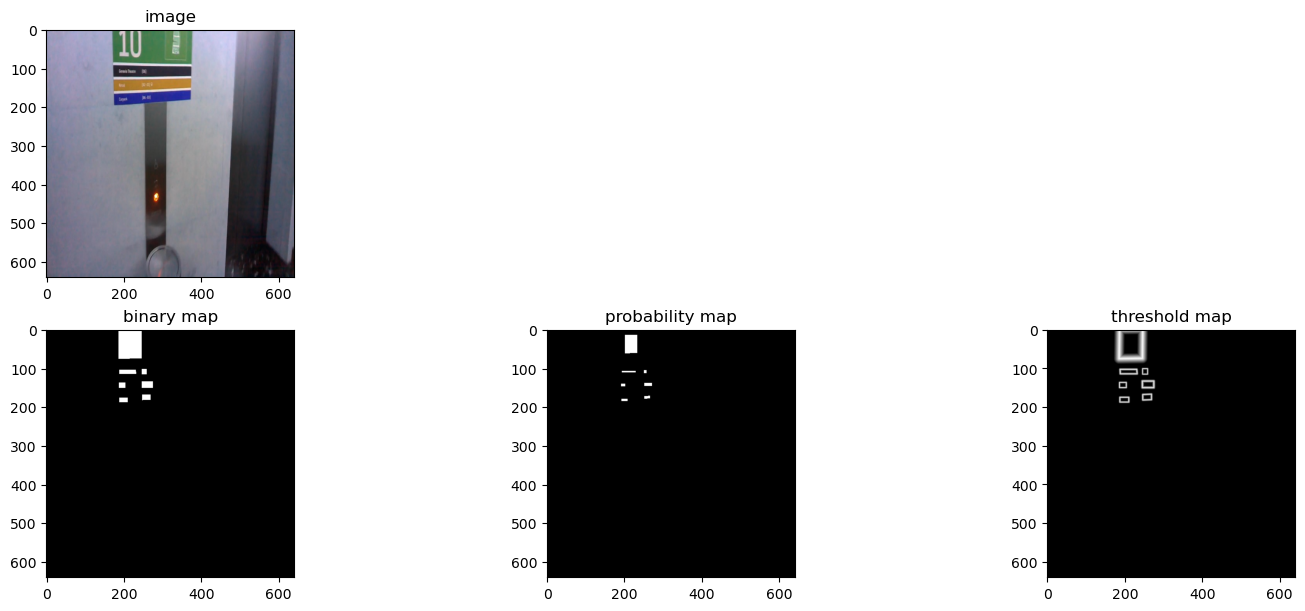

In [3]:
img, maps = dset[0]

fig = plt.figure(layout="constrained", figsize=(15, 6))
gs = fig.add_gridspec(2, 3)

ax1 = fig.add_subplot(gs[0, 0])
ax1.set_title("image")
ax1.imshow(img)

ax3 = fig.add_subplot(gs[1, 0])
ax3.set_title("binary map")
ax3.imshow(maps['bin_map'], cmap="gray")

ax4 = fig.add_subplot(gs[1, 1])
ax4.set_title("probability map")
ax4.imshow(maps['prob_map'], cmap="gray")

ax5 = fig.add_subplot(gs[1, 2])
ax5.set_title("threshold map")
ax5.imshow(maps['thresh_map'], cmap="gray")
ax5.set_xlim(0, maps['prob_map'].shape[0])
ax5.set_ylim(maps['prob_map'].shape[1], 0)

plt.show()